In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../Config')
from lablib import *

# Definizione funzioni

In [2]:
#Per la sezione di polarizzazione

def Malus_cmp_el(alfa, I0):
    return np.sqrt(I0)*(np.cos(alfa))

def Malus_onde_piane(alfa, I0):
    return I0*np.cos(alfa)**2

def Malus_onde_sferiche(alfa, I0, d):
    return (I0*(np.cos(alfa)/d)**2)

def Malus_combo(alfa, I0, A, B, C, D, E, F):
    return A*I0*np.cos(C*alfa + E) + B*I0*np.sin(D*alfa + F)

def Malus_disperazione(alfa, I0, A, B, C, D, E, F):
    return A*I0*(np.cos(alfa*C + E)) + B*I0*(np.sin(alfa*D + F))

#Sono da inserire di seguito le funzioni per fit dell'esperienza di polarizzazione
#Sono le funzioni al variare di theta e r 

#Per Brewster bisogna utilizzare un'iterpolazione parabolica
def parabola(x, a, b, c):
    return a*x**2 + b*x + c

def parabola_complete(x, a, b, c):
    return a*(x-b)**2 + c

#Per la sezione di interferenza dobbiamo scegliere due esperienza diverse. 
#Riporto comunque le funzioni per tutte e quattro

# #1 Per la sezione di interferenza con la doppia fenditura
# #massimi sono a: d*sin(theta) = n*lambda. Voglio ottenere theta
# def double_slit_max(n, d, l):
#     return np.arcsin(n*l/d)
    
# #minimi sono a: d*sin(theta) = (n/2)*lambda. Voglio ottenere theta
# def double_slit_min(n, d, l):
#     return np.arcsin(n*l/(2*d))


#2 Per la sezione di interferenza con specchio di LLoyd

#voglio ottenere n, sapendo che abbiamo misurato dei minimi
def lloyd_n_frangia(d, h):
    x = (2*h + 4*np.sqrt((d/2)**2 + h**2))/2.85
    return round(x)

#voglio ottenere solo lambda
def lloyd(d, h, n):
    return (2*h + 4*np.sqrt((d/2)**2 + h**2))/n

# #3 Per la sezione di interferenza con cavità di Fabry-Perot

# #voglio ottenere distanza tra i due schermi semiriflettenti
# def fabry_perot(l, m):
#     return m*l/2

#4 Per la sezione di interferenza con Michelson

#voglio ottenere lambda. N è il numero di frange contate nello spostamento x dello specchio
def michelson(N, x):
    return 2*x/N

# Per la sezione di diffrazione alla Bragg

#Il massimo si ha per 2*d*sin(theta) = n*lambda. Voglio ottenere d
def braggs(l, n, theta):
    return l/(2*np.sin(theta))

# Import dati

# POLARIZZAZIONE

**NOTA!!!**\
ricordiamoci dell'errore sulle x

Le misure degli angoli sono prese in gradi \
Le misure di intensità sono prese in volt \
Sensibilità goniometro = 5 gradi \
Sensibilità amperometro = 0.01 volt  \
Oscillazione amperometro = 0.05 \
Errore sistematico nel goniometro: non è possibile fare in modo che siano sempre dritti \
Tentiamo d prendere le misure con sempre la stessa inclinazione. \
Distanza tra i ricevitori (da dritti) = 50cm

In [3]:
dati_polatizzazione = pd.read_excel("dati_pol.xlsx")
rad_malus = np.deg2rad(dati_polatizzazione["gradi"])
rad_malus_err = np.deg2rad([2]*len(rad_malus))
amp_malus = dati_polatizzazione["tensione"]
amp_malus_err = [0.1]*len(amp_malus)
dist_malus = .5

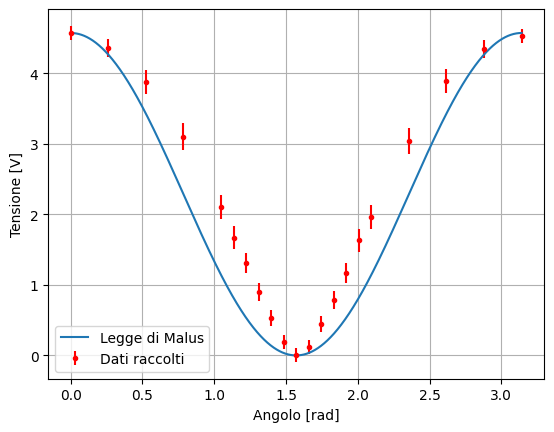

In [4]:
t1 = np.linspace(min(rad_malus), max(rad_malus), 100000)
malus_err_propagati = TrasportoErroriX2Y(rad_malus, rad_malus_err, amp_malus_err, lambda x: Malus_onde_piane(x, max(amp_malus)))

plt.errorbar(rad_malus, amp_malus, malus_err_propagati, label="Dati raccolti", fmt=".r")
plt.plot(t1, Malus_onde_piane(t1, max(amp_malus)), label="Legge di Malus")
#plt.plot(t1, Malus_onde_sferiche(t1, max(amp_malus), dist_malus)/Malus_onde_sferiche(0, max(amp_malus), dist_malus) * max(amp_malus), label="Malus onde sferiche", color="green", linestyle="--")
#plt.plot(t1, Malus_cmp_el(t1, max(amp_malus)), label="", color="blue")
plt.xlabel("Angolo [rad]")
plt.ylabel("Tensione [V]")
plt.grid()
plt.legend()
plt.show()

In [5]:
# test chi quadro manuale

def chi2(y, y_fit, sigma):
    return np.sum((y - y_fit)**2/sigma**2)

dof = len(amp_malus)

print(chi2(np.array(amp_malus), np.array(Malus_onde_piane(rad_malus, max(amp_malus))), np.array(malus_err_propagati))/dof)


12.717697127978616


In [6]:
#fit Malus disperazione

def func_disp(alfa, A, B, C, D, E, F):
    return Malus_disperazione(alfa, max(amp_malus), A, B, C, D, E, F)


pars_malus_d, vals_malus_d, ers_malus_d, *other_malus_d = LS_fit(rad_malus, amp_malus, amp_malus_err, func_disp, A=1, B=1, C=1, D=1, E=1, F=1)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 99.42 (χ²/ndof = 6.6)      │              Nfcn = 275              │
│ EDM = 8.5e-05 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │   0.457   │   0.006   │            │            │         │         │       │
│ 1 │ B    │    0.9    │    1.0    │            │            │         │         │       │
│ 2 │ C    │   2.310   │   0.027   │            │            │         │         │       │
│ 3 │ D    │  -0.003   │   0.012   │            │            │         │         │       │
│ 4 │ E    │   5.77    │   0.05    │            │            │         │         │       │
│ 5 │ F    │    0.7    │    1.0    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────────────────────────────────────────┐
│   │        A        B        C        D        E        F │
├───┼───────────────────────────────────────────────────────┤
│ A │ 4.06e-05       -0  0.01e-3        0 -0.01e-3  0.01e-3 │
│ B │       -0    0.978  -0.1e-3  5.68e-3   0.0001     -1.0 │
│ C │  0.01e-3  -0.1e-3 0.000745 -0.01e-3  -1.2e-3       -0 │
│ D │        0  5.68e-3 -0.01e-3 0.000135 -0.06e-3 -5.74e-3 │
│ E │ -0.01e-3   0.0001  -1.2e-3 -0.06e-3  0.00215   0.0002 │
│ F │  0.01e-3     -1.0       -0 -5.74e-3   0.0002    0.942 │
└───┴───────────────────────────────────────────────────────┘

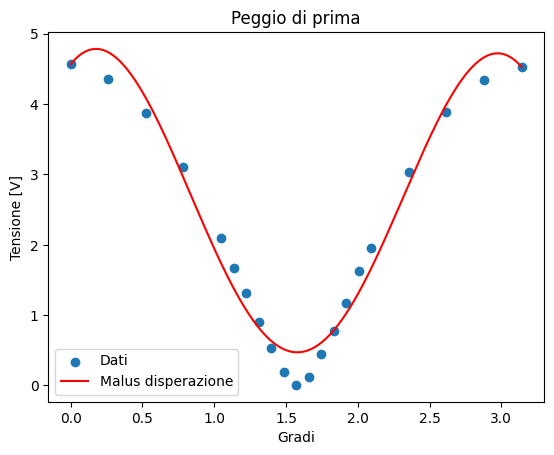

Parametro a: 1.4965645222674266 +- 0.1482798268179061
Parametro b: -1.5998118529525547 +- 0.14896721952876346
Parametro c: 1.673253276511294 +- 0.028056365751617365
Parametro d: 1.1236251655382452 +- 0.029301252373092466
Parametro e: 0.5058993620410479 +- 0.045692536299653926
Parametro f: -3.3364455440513203 +- 0.0460695026480897


In [7]:
# fit manuale per fissare i dati - non ho idea di come funzioni
# di base crea una funzione di costo personalizzata

x_fixed_points = [t1[0], t1[-1]]
y_fixed_values = [amp_malus[0], amp_malus[len(amp_malus)-1]]
penalty_weight = 10000  # Peso della penalità per fissare i punti

def chi_squared(a, b, c, d, e, f):
    model = func_disp

    y_model = model(rad_malus, a, b, c, d, e, f)
    chi2 = np.sum(((amp_malus - y_model) / amp_malus_err) ** 2)
    for x_fixed, y_fixed in zip(x_fixed_points, y_fixed_values):
        y_model_fixed = model(x_fixed, a, b, c, d, e, f)
        chi2 += penalty_weight * (y_model_fixed - y_fixed) ** 2
    return chi2

# Inizializzazione del fit
m_malus = Minuit(chi_squared, a=5, b=4, c=1, d=1, e=1, f=np.pi/2)
m_malus.errordef = Minuit.LEAST_SQUARES
m_malus.migrad()
val_fit = m_malus.values[:6]

# plot dei risultati

plt.scatter(rad_malus, amp_malus, label="Dati", marker="o")
plt.plot(t1, Malus_disperazione(t1, max(amp_malus), *val_fit), label="Malus disperazione", color="red")
plt.xlabel("Gradi")
plt.ylabel("Tensione [V]")
plt.title("Peggio di prima")
plt.legend()
plt.show()

for i in range(len(val_fit)):
    print(f"Parametro {m_malus.parameters[i]}: {val_fit[i]} +- {m_malus.errors[i]}")


# AMPIEZZA

## Rotazione

In [8]:
dati_rotazione = pd.read_excel("dati_rotazione.xlsx")
rad_rotaz_prec = np.deg2rad(dati_rotazione["gradi_precisi"])
rad_rotaz_prec_err = np.deg2rad([1 for _ in rad_rotaz_prec])
amp_rotaz = dati_rotazione["tensione_precisa"]
amp_rotaz_err = [0.05 for _ in amp_rotaz]

In [9]:
# fit per stabilire la potenza del coseno


def func_rot(alfa, A):
    return max(amp_rotaz)*np.cos(alfa)**A

rotaz_err_propagati = TrasportoErroriX2Y(rad_rotaz_prec, rad_rotaz_prec_err, amp_rotaz_err, lambda x: func_rot(x, 8))

pars_rot, vals_rot, ers_rot, *other_rot = LS_fit(rad_rotaz_prec, amp_rotaz, rotaz_err_propagati, func_rot, A=1, disp=1)

print(f"Va circa come un coseno alla {vals_rot[0]:.3g} +- {ers_rot[0]:.3g} potenza")

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 20.79 (χ²/ndof = 1.7)      │              Nfcn = 40               │
│ EDM = 1.21e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │   8.58    │   0.29    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────┐
│   │      A │
├───┼────────┤
│ A │ 0.0819 │
└───┴────────┘

Va circa come un coseno alla 8.58 +- 0.286 potenza


In [10]:
# fit con coseno generico

def cos_generico(alfa, A, B, C, D):
    return A*np.cos(B*alfa + C) + D

pars_rot_gen, vals_rot_gen, ers_rot_gen, *other_rot_gen = LS_fit(rad_rotaz_prec, amp_rotaz, rotaz_err_propagati, cos_generico, A=1, B=1, C=1, D=1)

for i in range(len(vals_rot_gen)):
    print(f"Parametro {pars_rot_gen[i]}: {vals_rot_gen[i]} +- {ers_rot_gen[i]}")

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 43.78 (χ²/ndof = 4.9)      │              Nfcn = 344              │
│ EDM = 3.83e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │   1.83    │   0.04    │            │            │         │         │       │
│ 1 │ B    │   3.22    │   0.12    │            │            │         │         │       │
│ 2 │ C    │   0.23    │   0.09    │            │            │         │         │       │
│ 3 │ D    │   1.80    │   0.04    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────┐
│   │       A       B       C       D │
├───┼─────────────────────────────────┤
│ A │ 0.00129 -0.0029  0.0023  0.0012 │
│ B │ -0.0029   0.014  -0.010 -0.0040 │
│ C │  0.0023  -0.010 0.00729  0.0032 │
│ D │  0.0012 -0.0040  0.0032 0.00179 │
└───┴─────────────────────────────────┘

Parametro A: 1.8330422608061019 +- 0.03590049510759393
Parametro B: 3.224185585251108 +- 0.1183766356444362
Parametro C: 0.233991631067385 +- 0.08540855369590987
Parametro D: 1.7979113716903912 +- 0.04229484615828872


In [11]:
# fit con coseno generico alla seconda 

def cos_generico_2(alfa, A, B, D):
    return A*np.cos(B*alfa)**D

pars_rot_gen_2, vals_rot_gen_2, ers_rot_gen_2, *other_rot_gen_2 = LS_fit(rad_rotaz_prec, amp_rotaz, rotaz_err_propagati, cos_generico_2, A=1, B=1, D=8)

for i in range(len(vals_rot_gen_2)):
    print(f"Parametro {pars_rot_gen_2[i]}: {vals_rot_gen_2[i]} +- {ers_rot_gen_2[i]}")

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 15.61 (χ²/ndof = 1.6)      │              Nfcn = 177              │
│ EDM = 5.95e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │   3.57    │   0.04    │            │            │         │         │       │
│ 1 │ B    │   1.40    │   0.28    │            │            │         │         │       │
│ 2 │ D    │    4.2    │    1.9    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────┐
│   │       A       B       D │
├───┼─────────────────────────┤
│ A │ 0.00148 -0.0025  0.0187 │
│ B │ -0.0025  0.0797   -0.54 │
│ D │  0.0187   -0.54    3.68 │
└───┴─────────────────────────┘

Parametro A: 3.5715806066080646 +- 0.03843329402116858
Parametro B: 1.4027014719825186 +- 0.2823788106039582
Parametro D: 4.183168476336825 +- 1.9178210541301195


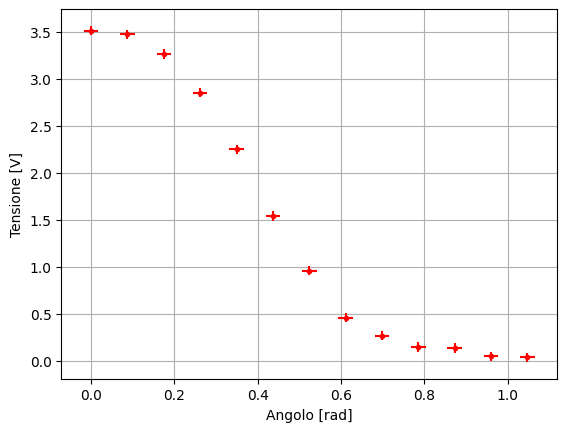

In [12]:
# plot dei dati di rotazione

t2 = np.linspace(min(rad_rotaz_prec), max(rad_rotaz_prec), 10000)

plt.errorbar(rad_rotaz_prec, amp_rotaz, amp_rotaz_err ,rad_rotaz_prec_err, fmt=".r")
plt.xlabel("Angolo [rad]")
plt.ylabel("Tensione [V]")
plt.grid()
plt.show()


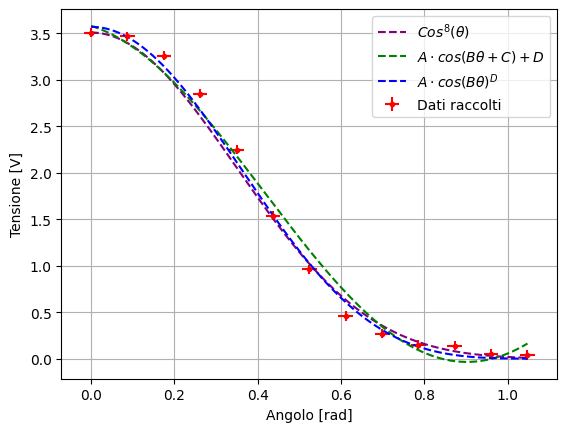

In [13]:
# plot dei risultati sullo stesso grafico

plt.errorbar(rad_rotaz_prec, amp_rotaz, amp_rotaz_err, rad_rotaz_prec_err, fmt=".r", label="Dati raccolti")
plt.plot(t2, func_rot(t2, *vals_rot), label=r"$Cos^8(\theta)$", color="purple", linestyle="--")
plt.plot(t2, cos_generico(t2, *vals_rot_gen), label=r"$A\cdot cos(B\theta + C) + D$", color="green", linestyle="--")
plt.plot(t2, cos_generico_2(t2, *vals_rot_gen_2), label=r"$A\cdot cos(B\theta)^D$", color="blue", linestyle="--")
plt.xlabel("Angolo [rad]")
plt.ylabel("Tensione [V]")
plt.legend()
plt.grid()
plt.show()

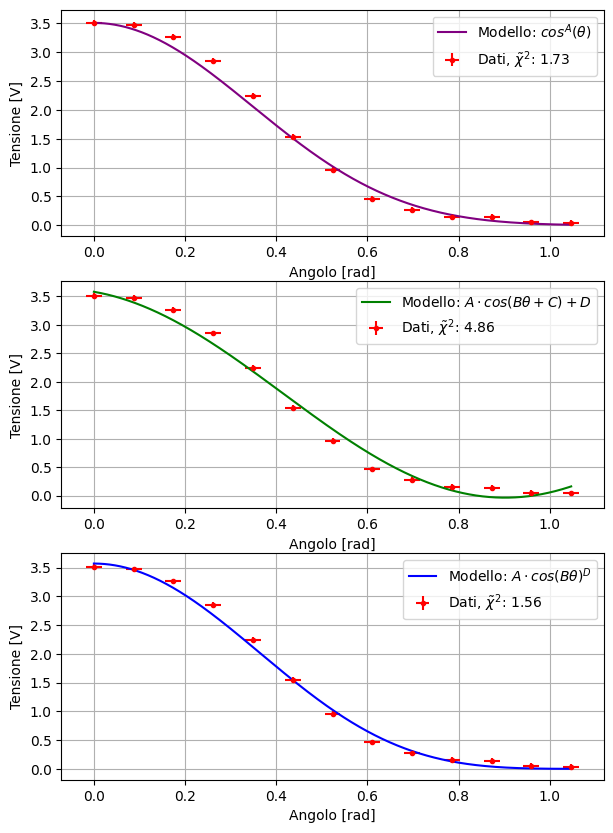

In [14]:
# plot dei risultati in grafici separati uno sotto l'altro

fig, axs = plt.subplots(3, 1, figsize=(7, 10))

axs[0].errorbar(rad_rotaz_prec, amp_rotaz, amp_rotaz_err, rad_rotaz_prec_err, fmt=".r", label="Dati raccolti")
axs[0].plot(t2, func_rot(t2, *vals_rot), color="purple")
axs[0].set_xlabel("Angolo [rad]")
axs[0].set_ylabel("Tensione [V]")
axs[0].legend([r"Modello: $cos^A(\theta)$", rf'Dati, $\tilde\chi^2$: {other_rot[2]/other_rot[1]:.3g}'])
axs[0].grid()

axs[1].errorbar(rad_rotaz_prec, amp_rotaz, amp_rotaz_err, rad_rotaz_prec_err, fmt=".r", label="Dati raccolti")
axs[1].plot(t2, cos_generico(t2, *vals_rot_gen), color="green")
axs[1].set_xlabel("Angolo [rad]")
axs[1].set_ylabel("Tensione [V]")
axs[1].legend([r"Modello: $A\cdot cos(B\theta + C) + D$", rf'Dati, $\tilde\chi^2$: {other_rot_gen[2]/other_rot_gen[1]:.3g}'])
axs[1].grid()

axs[2].errorbar(rad_rotaz_prec, amp_rotaz, amp_rotaz_err, rad_rotaz_prec_err, fmt=".r", label="Dati raccolti")
axs[2].plot(t2, cos_generico_2(t2, *vals_rot_gen_2), color="blue")
axs[2].set_xlabel("Angolo [rad]")
axs[2].set_ylabel("Tensione [V]")
axs[2].legend([r"Modello: $A\cdot cos(B\theta)^D$", rf'Dati, $\tilde\chi^2$: {other_rot_gen_2[2]/other_rot_gen_2[1]:.3g}'])
axs[2].grid()

plt.show()

**Commenti**

* La dipendenza dell'intensità da $cos^8(\theta)$  suggerisce che l'emettitore produce un fascio altamente direzionale. In altre parole, l'emissione è fortemente concentrata lungo un asse specifico e l'intensità diminuisce rapidamente con l'aumentare dell'angolo $\theta$ rispetto a questo asse.
* $cos^8(\theta)$ non segue perfettamente i dati, per cui possiamo aspettarci anche in questo caso una forma piu' complessa

## Distanza

Si può provare a fare i fit utilizzando solo i massimi o solo i minimi.

In [15]:
dati_distanza = pd.read_excel("dati_distanza.xlsx")
dist = dati_distanza["distanza"][7:]
dist_err = [0.3 for _ in dist]
amp3 = dati_distanza["tensione"][7:]
amp3_err = [0.05 for _ in amp3]


def modello_oscillante(x, A, B, C, D, E):
    return A*x + B + C*np.sin(D*x + E)

def modello_sottosmorzato(x, A, B, C, D, E):
    return A*np.exp(-B*x)*np.cos(C*x) + D*x + E

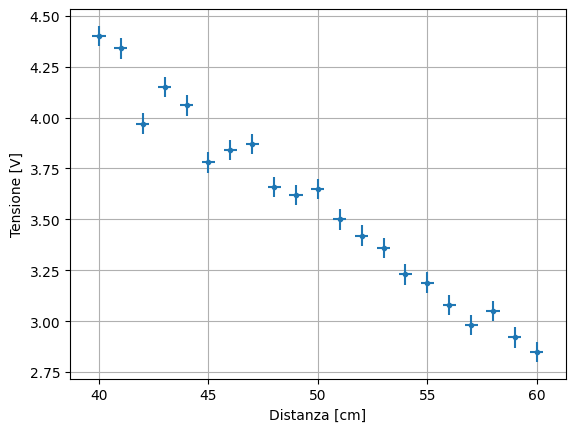

In [16]:
t3 = np.linspace(min(dist), max(dist), 100000)

plt.errorbar(dist, amp3, amp3_err, dist_err, fmt=".")
plt.xlabel("Distanza [cm]")
plt.ylabel("Tensione [V]")
plt.grid()
plt.show()

In [17]:
# x = np.linspace(1,100, 10000)
# plt.plot(x, -x+50 +4*np.cos(x))

pars_osc_1, vals_osc_1, ers_osc_1, *other_osc_1 = LS_fit(dist, amp3, amp3_err, modello_oscillante, A=1, B=1, C=1, D=1, E=1)

for i in range(len(vals_osc_1)):
    print(f"Parametro {pars_osc_1[i]}: {vals_osc_1[i]:.3g} +- {ers_osc_1[i]:.3g}")

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 45.67 (χ²/ndof = 2.9)      │              Nfcn = 354              │
│ EDM = 1.02e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │  -0.0745  │  0.0018   │            │            │         │         │       │
│ 1 │ B    │   7.29    │   0.09    │            │            │         │         │       │
│ 2 │ C    │   0.023   │   0.015   │            │            │         │         │       │
│ 3 │ D    │   1.00    │   0.07    │            │            │         │         │       │
│ 4 │ E    │     6     │     4     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────────────────────────────────────────────────────┐
│   │          A          B          C          D          E │
├───┼────────────────────────────────────────────────────────┤
│ A │   3.37e-06  -168.6e-6    -1.9e-6    21.1e-6 -1.1641e-3 │
│ B │  -168.6e-6    0.00856    0.08e-3     -0.001      0.061 │
│ C │    -1.9e-6    0.08e-3   0.000239          0    0.36e-3 │
│ D │    21.1e-6     -0.001          0    0.00534     -0.267 │
│ E │ -1.1641e-3      0.061    0.36e-3     -0.267       13.9 │
└───┴────────────────────────────────────────────────────────┘

Parametro A: -0.0745 +- 0.00184
Parametro B: 7.29 +- 0.0925
Parametro C: 0.0227 +- 0.0155
Parametro D: 0.997 +- 0.073
Parametro E: 5.8 +- 3.72


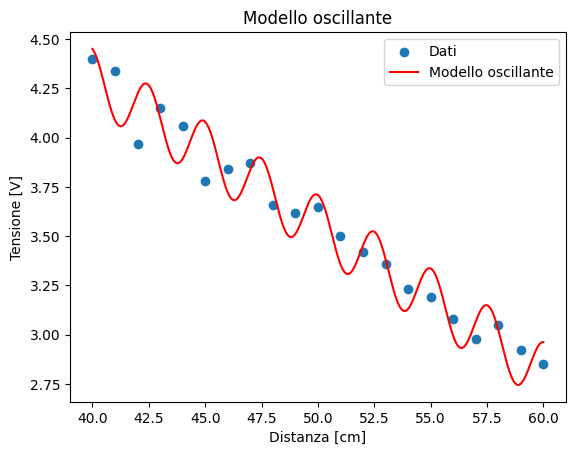

In [18]:
# plot dei risultati con valori modificati a mano

a_osc, b_osc, c_osc, d_osc , e_osc = vals_osc_1

plt.scatter(dist, amp3, label="Dati", marker="o")
plt.plot(t3, modello_oscillante(t3, a_osc, b_osc-.01, c_osc+.13, 1.5*d_osc+1, 2.5), label="Modello oscillante", color="red")
plt.xlabel("Distanza [cm]")
plt.ylabel("Tensione [V]")
plt.title("Modello oscillante")
plt.legend()
plt.show()

In [19]:
# tentativo di fit con modello 1/r

# ho provato un po' con questi modelli ma non funziona troppo
# def modello_1suR(x, A, T, omega, phi):
#     return (A*np.exp(-x/T)*np.cos(omega*x + phi))/x

# def modello_1suR_2(x, A, T, omega, phi):
#     return (A*np.exp(-x/T)*np.cos(omega*x + phi))/(x**2)

def mod_1suR(r, a, b):
    return a/r + b

pars1_1, vals1_1, ers1_1, *other1_1 = LS_fit(dist, amp3, amp3_err, mod_1suR, a=1, b=0)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 55.7 (χ²/ndof = 2.9)       │              Nfcn = 46               │
│ EDM = 2.97e-19 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │    179    │     4     │            │            │         │         │       │
│ 1 │ b    │   -0.07   │   0.09    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       a       b │
├───┼─────────────────┤
│ a │      19  -0.386 │
│ b │  -0.386 0.00795 │
└───┴─────────────────┘

In [20]:
# modello 1/r^2

def mod_1suR2(r, a, b):
    return a/r**2 + b

pars1_2, vals1_2, ers1_2, *other1_2 = LS_fit(dist, amp3, amp3_err, mod_1suR2, a=1, b=0.5)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 74.1 (χ²/ndof = 3.9)       │              Nfcn = 45               │
│ EDM = 8.01e-19 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  4.31e3   │  0.10e3   │            │            │         │         │       │
│ 1 │ b    │   1.76    │   0.05    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        a        b │
├───┼───────────────────┤
│ a │ 1.11e+04  -4.6390 │
│ b │  -4.6390  0.00206 │
└───┴───────────────────┘

In [21]:
# modello combinato

def mod_comb(r, a, b, c):
    return a/r + b/r**2 + c

pars1_3, vals1_3, ers1_3, *other1_3 = LS_fit(dist, amp3, amp3_err, mod_comb, a=1, b=1, c=0)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 46.78 (χ²/ndof = 2.6)      │              Nfcn = 87               │
│ EDM = 1.29e-14 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │    420    │    80     │            │            │         │         │       │
│ 1 │ b    │  -5.8e3   │   1.9e3   │            │            │         │         │       │
│ 2 │ c    │   -2.5    │    0.8    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────────────────────────┐
│   │        a        b        c │
├───┼────────────────────────────┤
│ a │ 6.38e+03   -154e3    -65.2 │
│ b │   -154e3 3.72e+06 1.5667e3 │
│ c │    -65.2 1.5667e3    0.667 │
└───┴────────────────────────────┘

In [22]:
# modello lineare

def mod_lin(r, a, b):
    return a*r + b

pars1_4, vals1_4, ers1_4, *other1_4 = LS_fit(dist, amp3, amp3_err, mod_lin, a=1, b=0)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 47.83 (χ²/ndof = 2.5)      │              Nfcn = 55               │
│ EDM = 2.25e-18 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  -0.0743  │  0.0018   │            │            │         │         │       │
│ 1 │ b    │   7.28    │   0.09    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────┐
│   │         a         b │
├───┼─────────────────────┤
│ a │  3.25e-06 -162.3e-6 │
│ b │ -162.3e-6   0.00824 │
└───┴─────────────────────┘

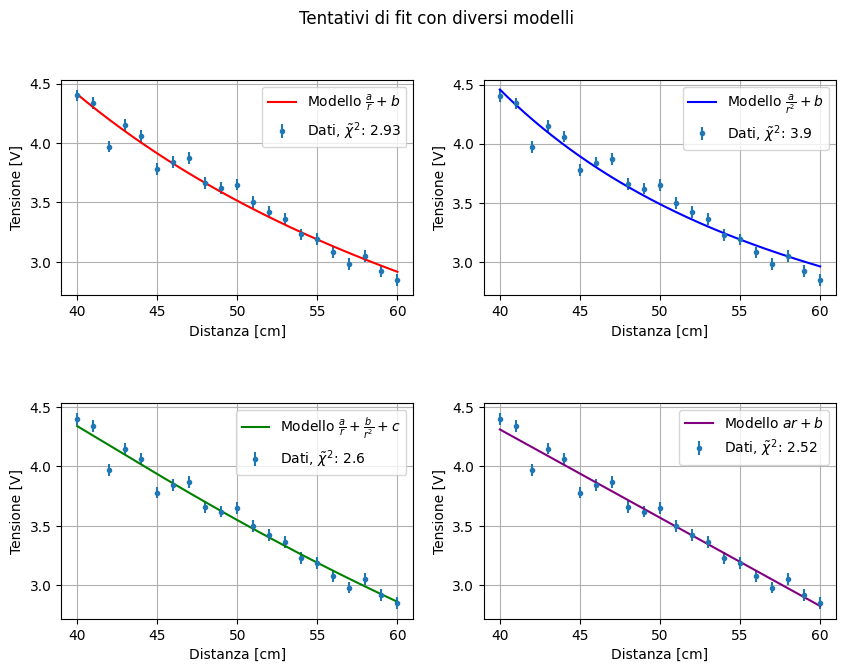

In [23]:
# plotta i 4 grafici precedenti in un unico grafico 2x2

t4 = np.linspace(min(dist), max(dist), 10000)

fig, axs = plt.subplots(2, 2, figsize=(10, 7))
fig.suptitle("Tentativi di fit con diversi modelli")

fig.subplots_adjust(hspace=0.5)

axs[0, 0].errorbar(dist, amp3, yerr=amp3_err, fmt='.', label="Dati")
axs[0, 0].plot(t4, mod_1suR(t4, *vals1_1), color="red")
axs[0, 0].legend([r"Modello $\frac{a}{r} + b$", rf'Dati, $\tilde\chi^2$: {other1_1[2]/other1_1[1]:.3g}'])
axs[0, 0].set_xlabel("Distanza [cm]")
axs[0, 0].set_ylabel("Tensione [V]")
axs[0, 0].grid()

axs[0, 1].errorbar(dist, amp3, yerr=amp3_err, fmt='.', label="Dati")
axs[0, 1].plot(t4, mod_1suR2(t4, *vals1_2), label="Modello 1/r^2", color="blue")
axs[0, 1].legend([r"Modello $\frac{a}{r^2} + b$", rf'Dati, $\tilde\chi^2$: {other1_2[2]/other1_2[1]:.3g}'])
axs[0, 1].set_xlabel("Distanza [cm]")
axs[0, 1].set_ylabel("Tensione [V]")
axs[0, 1].grid()

axs[1, 0].errorbar(dist, amp3, yerr=amp3_err, fmt='.', label="Dati")
axs[1, 0].plot(t4, mod_comb(t4, *vals1_3), label="Modello combinato", color="green")
axs[1, 0].legend([r"Modello $\frac{a}{r} + \frac{b}{r^2} + c$", rf'Dati, $\tilde\chi^2$: {other1_3[2]/other1_3[1]:.3g}'])
axs[1, 0].set_xlabel("Distanza [cm]")
axs[1, 0].set_ylabel("Tensione [V]")
axs[1, 0].grid()

axs[1, 1].errorbar(dist, amp3, yerr=amp3_err, fmt='.', label="Dati")
axs[1, 1].plot(t4, mod_lin(t4, *vals1_4), label="Modello lineare", color="purple")
axs[1, 1].legend([r"Modello $a  r + b$", rf'Dati, $\tilde\chi^2$: {other1_4[2]/other1_4[1]:.3g}'])
axs[1, 1].set_xlabel("Distanza [cm]")
axs[1, 1].set_ylabel("Tensione [V]")
axs[1, 1].grid()

plt.show()

In [24]:
# plot con le misure più fitte
# le misure oscillavano di meno

dist_prec = dati_distanza["distanza_precisa"].dropna()
dist_prec_err = [0.1 for _ in dist_prec]
amp3_prec = dati_distanza["tensione_precisa"].dropna()
amp3_prec_err = [0.02 for _ in amp3_prec]

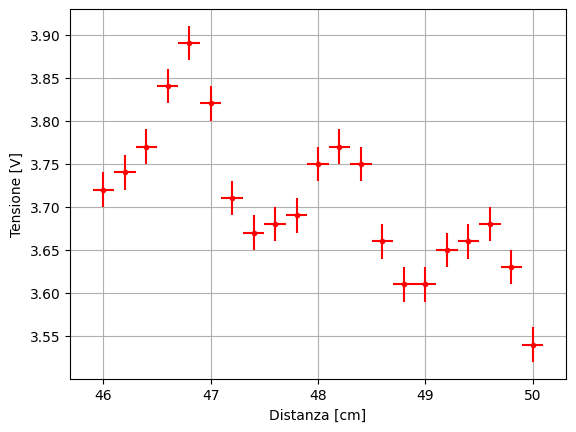

In [25]:
plt.errorbar(dist_prec, amp3_prec, amp3_prec_err, dist_prec_err, fmt=".r")
plt.xlabel("Distanza [cm]")
plt.ylabel("Tensione [V]")
plt.grid()
plt.show()

In [26]:
# fit con modello oscillante

t4 = np.linspace(min(dist_prec), max(dist_prec), 100000)

pars_osc_2, vals_osc_2, ers_osc_2, *other_osc_2 = LS_fit(dist_prec, amp3_prec, amp3_prec_err, modello_oscillante, A=1, B=1, C=1, D=3, E=1)

for i in range(len(vals_osc_2)):
    print(f"Parametro {pars_osc_2[i]}: {vals_osc_2[i]:.3g} +- {ers_osc_2[i]:.3g}")

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 18.14 (χ²/ndof = 1.1)      │              Nfcn = 493              │
│ EDM = 2.66e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │  -0.057   │   0.004   │            │            │         │         │       │
│ 1 │ B    │   6.43    │   0.18    │            │            │         │         │       │
│ 2 │ C    │   0.077   │   0.006   │            │            │         │         │       │
│ 3 │ D    │   4.56    │   0.06    │            │            │         │         │       │
│ 4 │ E    │   -67.5   │    3.1    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────────────────────────────────────┐
│   │         A         B         C         D         E │
├───┼───────────────────────────────────────────────────┤
│ A │  1.42e-05 -0.680e-3 -0.005e-3  0.032e-3 -1.472e-3 │
│ B │ -0.680e-3    0.0326   0.22e-3    -0.001     0.068 │
│ C │ -0.005e-3   0.22e-3  3.96e-05  -0.01e-3   0.43e-3 │
│ D │  0.032e-3    -0.001  -0.01e-3   0.00417    -0.200 │
│ E │ -1.472e-3     0.068   0.43e-3    -0.200      9.56 │
└───┴───────────────────────────────────────────────────┘

Parametro A: -0.0568 +- 0.00376
Parametro B: 6.43 +- 0.181
Parametro C: 0.0773 +- 0.00629
Parametro D: 4.56 +- 0.0646
Parametro E: -67.5 +- 3.09


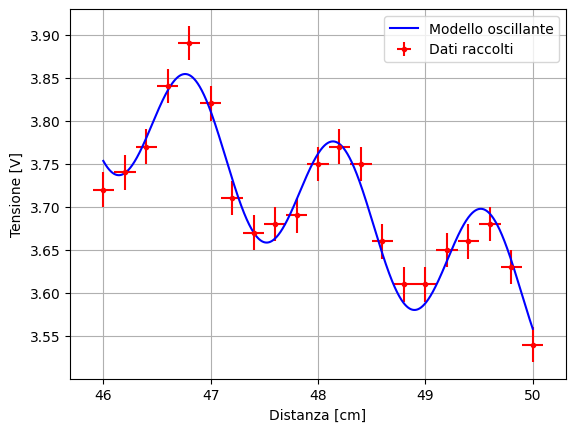

In [27]:
# plot dei risultati

plt.errorbar(dist_prec, amp3_prec, amp3_prec_err, dist_prec_err, fmt=".r", label="Dati raccolti")
plt.plot(t4, modello_oscillante(t4, *vals_osc_2), label="Modello oscillante", color="blue")
plt.xlabel("Distanza [cm]")
plt.ylabel("Tensione [V]")
plt.legend()
plt.grid()
plt.show()

In [28]:
dist_x_err = [.3]*len(dist_prec)
amp3_prec_err = [0.01]*len(amp3_prec)
dist_err_propagati = TrasportoErroriX2Y(dist_prec, dist_x_err, amp3_prec_err, lambda x: modello_oscillante(x, *vals_osc_2))

pars_osc_3, vals_osc_3, ers_osc_3, *other_osc_3 = LS_fit(dist_prec, amp3_prec, dist_err_propagati, modello_oscillante, A=1, B=1, C=1, D=4, E=1)

lambda_stimata = 4*np.pi/vals_osc_2[3]
lambda_stimata_err = 4*np.pi*ers_osc_2[3]/vals_osc_2[3]**2
print(f"Lunghezza d'onda stimata: {lambda_stimata:.3g} +- {lambda_stimata_err:.3g}")

print(f"Test di compatibilità: {TestCompatibilita(lambda_stimata, lambda_stimata_err, 2.85)}")

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5.448 (χ²/ndof = 0.3)      │              Nfcn = 414              │
│ EDM = 2.7e-05 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │  -0.061   │   0.008   │            │            │         │         │       │
│ 1 │ B    │    6.6    │    0.4    │            │            │         │         │       │
│ 2 │ C    │   0.079   │   0.010   │            │            │         │         │       │
│ 3 │ D    │   4.57    │   0.23    │            │            │         │         │       │
│ 4 │ E    │    -30    │    11     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────────────────────────────────────────┐
│   │        A        B        C        D        E │
├───┼──────────────────────────────────────────────┤
│ A │ 5.85e-05 -2.78e-3 -0.02e-3 -0.76e-3 35.89e-3 │
│ B │ -2.78e-3    0.133  0.89e-3     0.04    -1.70 │
│ C │ -0.02e-3  0.89e-3 9.08e-05  0.05e-3 -1.99e-3 │
│ D │ -0.76e-3     0.04  0.05e-3   0.0524    -2.47 │
│ E │ 35.89e-3    -1.70 -1.99e-3    -2.47      117 │
└───┴──────────────────────────────────────────────┘

Lunghezza d'onda stimata: 2.75 +- 0.039
Test di compatibilità: 2.471759881560981


In [29]:
# # fit con modello sottosmorzato

# pars_osc_4, vals_osc_4, ers_osc_4, *other_osc_4 = LS_fit(dist_prec, amp3_prec, amp3_prec_err, modello_sottosmorzato, A=2, B=1, C=4, D=-5, E=1)

# for i in range(len(vals_osc_4)):
#     print(f"Parametro {pars_osc_4[i]}: {vals_osc_4[i]:.3g} +- {ers_osc_4[i]:.3g}")


# ANGOLO DI BREWSTER

tensione senza polietilene $\approx$ 2.95 \
errore sulle x (gradi) = 0.5 \
indice rifrazione polietilene = 1.575

Scelto mezzo grado di errore perchè, sebbene sotto la sensibilità del goniometro, l'asta del ricevitore si trovava precisamente sulla tacca del grado

In [30]:
#Raccolta dati per Brewster in trasmissione
dati_brewster_trasm = pd.read_excel("dati_brewster_trasm.xlsx")
gradi_br = dati_brewster_trasm["angolo"]
amp_br_tr_oriz = dati_brewster_trasm["tensione(oriz)"]
amp_br_tr_vert = dati_brewster_trasm["tensione(vert)"]
amp_br_tr_err = [0.03]*len(amp_br_tr_vert)
gradi_br_err = [0.5]*len(gradi_br)      

#Raccolta dati per Brewster in riflessione
dati_brewster_rifl = pd.read_excel("dati_brewster_rifl.xlsx")
gradi_br_rifl = dati_brewster_rifl["angolo(specchio)"]
amp_br_rifl_oriz = dati_brewster_rifl["tensione(polar. oriz.)"]
amp_br_rifl_vert = dati_brewster_rifl["tensione(polar. vert.)"]
gradi_br_g1 = dati_brewster_rifl["angolo(specchio)(giorno1)"]
amp_br_rifl_g1 = dati_brewster_rifl["tensione(giorno1)"]
amp_br_rifl_err = [0.03 for _ in amp_br_rifl_vert]


#Diamo una stima di quanto dovrebbe uscire, conoscendo gli indici di rifrazione
indice_rifr1 = 1.00029
indice_rifr2 = 1.5
theta_br_atteso_rad = np.arctan(indice_rifr2/indice_rifr1)
theta_br_atteso_deg = np.rad2deg(theta_br_atteso_rad)
theta_br_atteso_err = 0
print(f"Theta atteso: {theta_br_atteso_deg :.2f}")

Theta atteso: 56.30


## Trasmissione

Per la trasmissione ci sono da escludere le misure dopo gli azzeramenti delle intensità: infatti dopo un certo angolo la tensione torna a crescere perchè il raggio dell'emettitore sorpassa la lastra senza effettuare il fenomeno che vogliamo

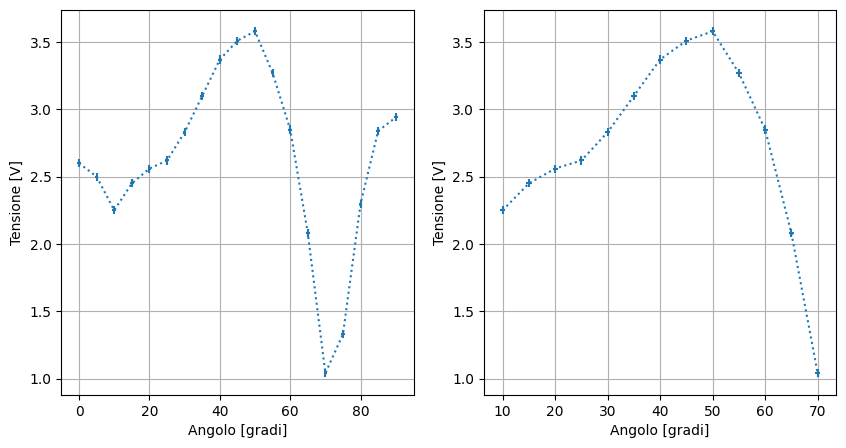

In [31]:
# plot di Brewster in trasmissione con polarizzazione orizzontale

N_misura_tras_oriz = 15

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
#axs[0].plot(gradi_br, amp_br_tr_oriz, label="Dati raccolti", marker="o")
axs[0].errorbar(gradi_br, amp_br_tr_oriz, amp_br_tr_err, gradi_br_err, linestyle="dotted")
axs[0].set_xlabel("Angolo [gradi]")
axs[0].set_ylabel("Tensione [V]")
axs[0].grid()

axs[1].errorbar(gradi_br[2:N_misura_tras_oriz], amp_br_tr_oriz[2:N_misura_tras_oriz], amp_br_tr_err[2:N_misura_tras_oriz], gradi_br_err[2:N_misura_tras_oriz], linestyle="dotted")
axs[1].set_xlabel("Angolo [gradi]")
axs[1].set_ylabel("Tensione [V]")
axs[1].grid()

In [32]:
#Da sistemare la questione di propagazione degli errori x sull'asse y

first_point = 8
secnd_point = 13

dati_br_fit = amp_br_tr_oriz[first_point:secnd_point]
dati_br_fit_err = amp_br_tr_err[first_point:secnd_point]
gradi_br_fit = gradi_br[first_point:secnd_point]
gradi_br_err_fit = gradi_br_err[first_point:secnd_point] 

pars2, vals2, ers2, *other2 = LS_fit(gradi_br_fit, dati_br_fit, dati_br_fit_err, parabola_complete, 
                                     a=-4.65e-3, b=47.13, c=3.5, disp=0)


dati_br_prop_err = TrasportoErroriX2Y(gradi_br_fit, gradi_br_err_fit, amp_br_tr_err[first_point:secnd_point], lambda x: parabola_complete(x, *vals2))
dati_br_prop_err_fit = dati_br_prop_err[first_point:secnd_point]


pars2_1, vals2_1, ers2_1, *other2_1 = LS_fit(gradi_br_fit, dati_br_fit, dati_br_prop_err, parabola_complete,
                                    a=-4.65e-3, b=47.13, c=3.5)

#test di compatibilità
comp_brew_1 = TestCompatibilita(vals2_1[2],ers2_1[2], theta_br_atteso_rad, theta_br_atteso_err)

#stampa dei risultati
print(f"Distanza in deviazioni standard: {comp_brew_1:.2f}")


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4.331 (χ²/ndof = 2.2)      │              Nfcn = 77               │
│ EDM = 4.3e-05 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  -4.4e-3  │  0.5e-3   │            │            │         │         │       │
│ 1 │ b    │   47.2    │    0.4    │            │            │         │         │       │
│ 2 │ c    │   3.570   │   0.023   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────────────────────────────┐
│   │          a          b          c │
├───┼──────────────────────────────────┤
│ a │   2.25e-07 -106.99e-6   -6.72e-6 │
│ b │ -106.99e-6      0.171     2.1e-3 │
│ c │   -6.72e-6     2.1e-3   0.000518 │
└───┴──────────────────────────────────┘

Distanza in deviazioni standard: 113.65


per spiegare il picco iniziale, le onde vengono riflesse più volte, quindi leggiamo un segnale maggiore. \
per spiegare il picco finale, semplicemente parte delle onde raggiunge il ricevitore inimpedita, quindi non c'è perdita di segnale

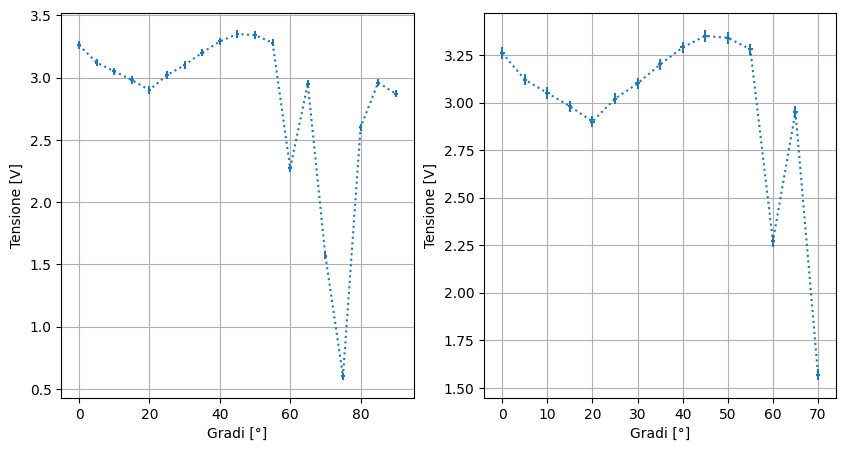

In [33]:
N_misura_tras_vert = 15

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].errorbar(gradi_br, amp_br_tr_vert, amp_br_tr_err, gradi_br_err, linestyle="dotted")
axes[0].set_xlabel("Gradi [°]")
axes[0].set_ylabel("Tensione [V]")
axes[0].grid()

axes[1].errorbar(gradi_br[:N_misura_tras_vert], amp_br_tr_vert[:N_misura_tras_vert], amp_br_tr_err[:N_misura_tras_vert], gradi_br_err[:N_misura_tras_vert], linestyle="dotted")
axes[1].set_xlabel("Gradi [°]")
axes[1].set_ylabel("Tensione [V]")
axes[1].grid()

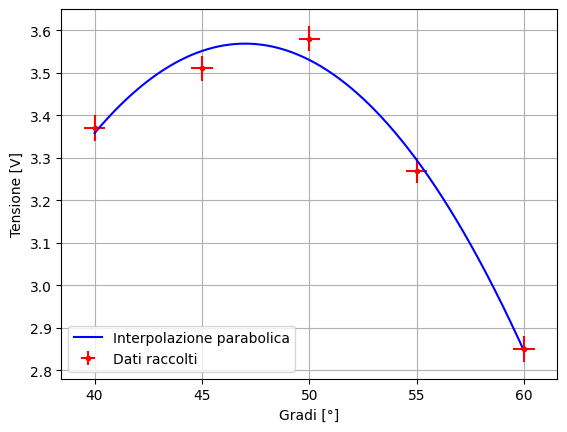

In [34]:
#Grafico di interpolazione da inserire nella relazione

#Brewster in trasmissione, polarizzazione orizzontale, con interpolazione parabolica

t5 = np.linspace(gradi_br[first_point], gradi_br[secnd_point-1], 10000)
plt.errorbar(gradi_br[first_point:secnd_point], amp_br_tr_oriz[first_point:secnd_point], amp_br_tr_err[first_point:secnd_point], gradi_br_err[first_point:secnd_point] ,label="Dati raccolti", fmt=".r")
plt.plot(t5, parabola_complete(t5, *vals2), label="Interpolazione parabolica", color="blue")
plt.xlabel("Gradi [°]")
plt.ylabel("Tensione [V]")
plt.legend()
plt.grid()


## Riflessione

L'angolo è stato preso in base alla lastra di polietilene: ruotando la lastra, misuriamo l'angolo e spostiamo l'emettitore in modo da avere 180-2*$\theta$ (per la legge degli angoli o qualcosa) \
Ad esempio: se lo specchio è a 30°, l'emettitore sarà a 180°-60° = 120°

### Giornata 1

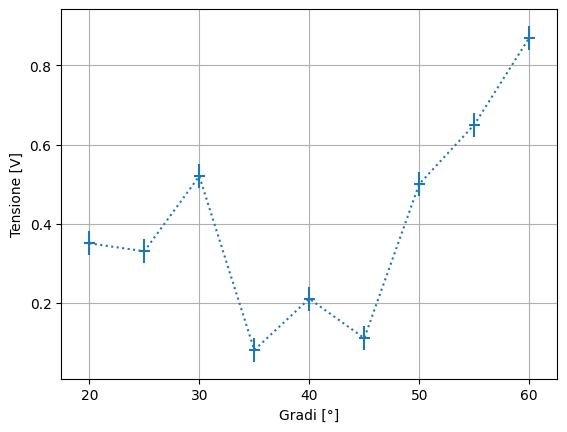

In [35]:
N_misura_rifl_g1 = len(gradi_br_g1)

plt.errorbar(gradi_br_g1, amp_br_rifl_g1, amp_br_rifl_err, gradi_br_err[:N_misura_rifl_g1], linestyle="dotted")
plt.xlabel("Gradi [°]")
plt.ylabel("Tensione [V]")
plt.grid()


### Giornata 2

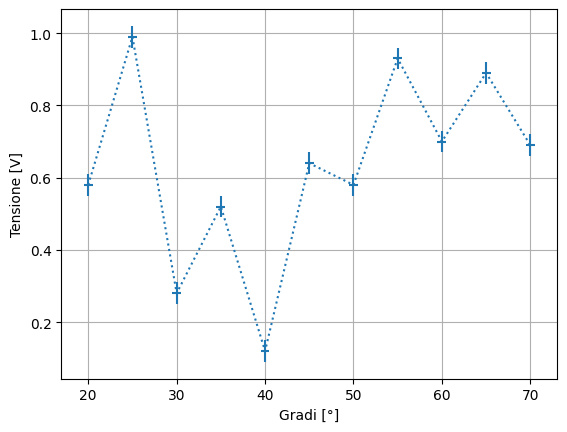

In [36]:
N_misura_rifl_oriz = len(gradi_br_rifl)

plt.errorbar(gradi_br_rifl, amp_br_rifl_oriz, amp_br_rifl_err, gradi_br_err[:N_misura_rifl_oriz], linestyle="dotted")
plt.xlabel("Gradi [°]")
plt.ylabel("Tensione [V]")
plt.grid()



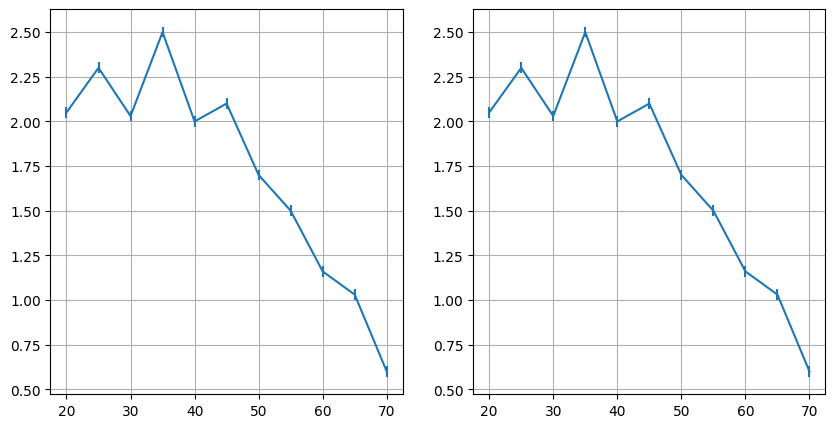

In [37]:
N_misura_rifl_vert = len(gradi_br_rifl)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].errorbar(gradi_br_rifl, amp_br_rifl_vert, amp_br_rifl_err)
ax[0].grid()

ax[1].errorbar(gradi_br_rifl[:N_misura_rifl_vert], amp_br_rifl_vert[:N_misura_rifl_vert], amp_br_rifl_err[:N_misura_rifl_vert])
ax[1].grid()

# DIFFRAZIONE DI BRAGG

La condizione di Bragg si verifica quando la differenza di cammino ottico tra i riflessi dai vari piani del cristallo da luogo a interferenza costruttiva:

n $\lambda$ = 2dsin $\theta$

lunghezza d'onda tabulata = 2.85cm

Piano parallelo utilizzato famiglia (100) quindi n = 1



Giorno 2 abbiamo preso ogni 2 gradi il cubo e di conseguenza 4 gradi il ricevitore 
a partire da 90 fino a 160



In [85]:
dati_bragg = pd.read_excel("dati_bragg.xlsx")
rad_bragg = np.deg2rad(dati_bragg["angolo(giorno2)"])
rad_bragg_err = np.array([0.017 for _ in rad_bragg])
amp_bragg = dati_bragg["tensione(giorno2)"]
amp_bragg_err = [0.05 for i in amp_bragg]

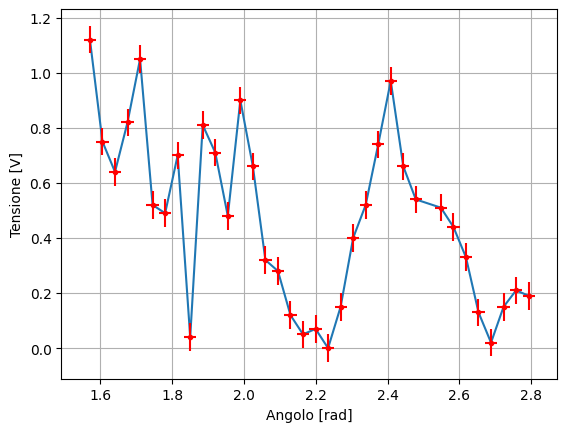

In [86]:
plt.plot(rad_bragg, amp_bragg)
plt.errorbar(rad_bragg, amp_bragg, xerr=rad_bragg_err, yerr=amp_bragg_err, fmt=".r", ecolor="red")
plt.xlabel("Angolo [rad]")
plt.ylabel("Tensione [V]")
plt.grid()
plt.show()
# I vari picchi strani del grafico rappresentano diffrazioni da vari piani oltre al nostro con indici 100

In [40]:
#stima approssimativa con media dei picchi per d

angoli_picchi_deg = [136,138,140]
angoli_picchi_rad = np.radians(angoli_picchi_deg)

lambda_microwave = 2.85  # cm

# Calcola d per ogni angolo di incidenza
d_values = []
for theta in angoli_picchi_rad:
    d = lambda_microwave / (2 * np.sin(theta))
    d_values.append(d)
    
d_media = np.mean(d_values)
d_std = np.std(d_values)
print(f"Distanza media tra i piani atomici d: {d_media:.2f} ± {d_std:.2f} cm")



Distanza media tra i piani atomici d: 2.13 ± 0.07 cm


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 11.82 (χ²/ndof = 2.4)      │              Nfcn = 136              │
│ EDM = 6.36e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  -0.0071  │  0.0013   │            │            │         │         │       │
│ 1 │ b    │   139.2   │    0.5    │            │            │         │         │       │
│ 2 │ c    │   0.76    │   0.05    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────────────────────────┐
│   │        a        b        c │
├───┼────────────────────────────┤
│ a │ 1.68e-06 314.8e-6 -39.6e-6 │
│ b │ 314.8e-6    0.261  -0.0019 │
│ c │ -39.6e-6  -0.0019  0.00209 │
└───┴────────────────────────────┘

Stima di b dalla parabola : 139 +- 0.51 cm
Stima della distanza d con b della parabola: 2.17 +- 0.656 cm 


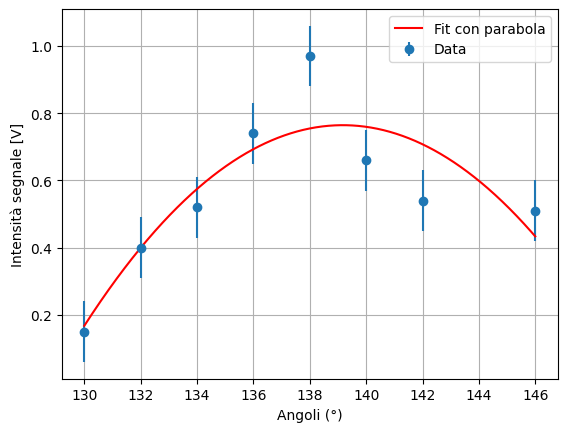

In [41]:

angoli = np.array([130, 132, 134, 136, 138, 140, 142, 146])
intensità = np.array([0.15, 0.40, 0.52, 0.74, 0.97, 0.66, 0.54, 0.51])
intensità_err = np.array([0.09 for _ in intensità])


def parabola_complete(x, a, b, c):
    return a * (x - b) ** 2 + c

params, vals, errs, pval, dof, chi_quadro, cov = LS_fit(angoli,intensità,intensità_err, parabola_complete, a=1, b=np.mean(angoli), c=np.mean(intensità))
b_best = vals[1]
b_err = errs[1]
d_best = 2.85 / (2*np.sin(np.deg2rad(139)))
d_err= (2.85 * np.abs(np.cos(b_best)) / (2 * np.sin(b_best)**2)) * b_err

print(f"Stima di b dalla parabola : {b_best:.3g} +- {b_err:.3g} cm")
print(f"Stima della distanza d con b della parabola: {d_best:.3g} +- {d_err:.3g} cm ") 

x_fit = np.linspace(np.min(angoli), np.max(angoli), 1000)
y_fit = parabola_complete(x_fit, *vals)

plt.errorbar(angoli, intensità, yerr=intensità_err, fmt='o', label='Data')
plt.plot(x_fit, y_fit, label='Fit con parabola', color='red')
plt.xlabel('Angoli (°)')
plt.ylabel('Intensità segnale [V]')
plt.grid()
plt.legend()
plt.show()




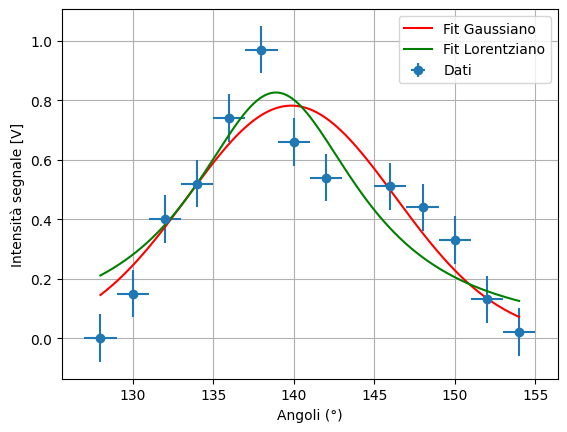

Fit Gaussiano: A = 0.782 ± 0.070, mu = 139.861 ± 0.669, sigma = 6.463 ± 0.667
Fit Lorentziano: A = 0.826 ± 0.093, x0 = 138.898 ± 0.767, w = 6.379 ± 1.149
Chi-quadro ridotto per il fit Gaussiano: 2.528
Chi-quadro ridotto per il fit Lorentziano: 3.166


In [95]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Nuovi dati forniti
angoli = np.array([128, 130, 132, 134, 136, 138, 140, 142, 146, 148, 150, 152, 154])
angoli_err = np.array([1 for _ in angoli])
intensità = np.array([0, 0.15, 0.40, 0.52, 0.74, 0.97, 0.66, 0.54, 0.51, 0.44, 0.33, 0.13, 0.02])
intensità_err = np.array([0.08 for _ in intensità])

# Funzione Gaussiana
def gaussiana(x, A, mu, sigma):
    return A * np.exp(- (x - mu)**2 / (2 * sigma**2))

# Funzione Lorentziana
def lorentziana(x, A, x0, w):
    return A * (w**2 / ((x - x0)**2 + w**2))

# Fit con la funzione Gaussiana
popt_gauss, pcov_gauss = curve_fit(gaussiana, angoli, intensità, sigma=intensità_err, p0=[1, np.mean(angoli), 1])
perr_gauss = np.sqrt(np.diag(pcov_gauss))

# Fit con la funzione Lorentziana
popt_lorentz, pcov_lorentz = curve_fit(lorentziana, angoli, intensità, sigma=intensità_err, p0=[1, np.mean(angoli), 1])
perr_lorentz = np.sqrt(np.diag(pcov_lorentz))

# Valori di x per il grafico del fit
x_fit = np.linspace(np.min(angoli), np.max(angoli), 1000)
y_fit_gauss = gaussiana(x_fit, *popt_gauss)
y_fit_lorentz = lorentziana(x_fit, *popt_lorentz)

# Plot dei dati e dei fit
plt.errorbar(angoli, intensità,xerr=angoli_err,yerr=intensità_err, fmt='o', label='Dati')
plt.plot(x_fit, y_fit_gauss, label='Fit Gaussiano', color='red')
plt.plot(x_fit, y_fit_lorentz, label='Fit Lorentziano', color='green')
plt.xlabel('Angoli (°)')
plt.ylabel('Intensità segnale [V]')
plt.grid()
plt.legend()
plt.show()

# Stampa dei risultati del fit
print(f"Fit Gaussiano: A = {popt_gauss[0]:.3f} ± {perr_gauss[0]:.3f}, mu = {popt_gauss[1]:.3f} ± {perr_gauss[1]:.3f}, sigma = {popt_gauss[2]:.3f} ± {perr_gauss[2]:.3f}")
print(f"Fit Lorentziano: A = {popt_lorentz[0]:.3f} ± {perr_lorentz[0]:.3f}, x0 = {popt_lorentz[1]:.3f} ± {perr_lorentz[1]:.3f}, w = {popt_lorentz[2]:.3f} ± {perr_lorentz[2]:.3f}")

# Calcolo chi-quadro ridotto per entrambi i modelli
chi2_gauss = np.sum(((intensità - gaussiana(angoli, *popt_gauss)) / intensità_err) ** 2)
chi2_lorentz = np.sum(((intensità - lorentziana(angoli, *popt_lorentz)) / intensità_err) ** 2)
dof = len(angoli) - len(popt_gauss)  # gradi di libertà

chi2_reduced_gauss = chi2_gauss / dof
chi2_reduced_lorentz = chi2_lorentz / dof

print(f"Chi-quadro ridotto per il fit Gaussiano: {chi2_reduced_gauss:.3f}")
print(f"Chi-quadro ridotto per il fit Lorentziano: {chi2_reduced_lorentz:.3f}")



# INTERFERENZA

## Michelson & Morley

**Posizioni iniziali** (distanze dal centro)
* emettitore = $26 \pm 0.3$ cm
* ricevitore = $28 \pm 0.3$ cm
* specchio b = $24.2 \pm 0.3$ cm
* specchio a (mobile) = $28.1 \pm 3$ cm --- segnato = 38.7 cm (sul metro)
* lunghezza del supporto = 4.5cm

Scheda lab chiede ricostruire:
* posizione massimi : li abbiamo effettivamente trovati ogni lambda/2 interf costrutt
* lambda : λ=2Δx/n
* intensità segnale funzione della distanza r (non abbiamo campionato abbastanza ogni frangia ma va bene cosi)


​
 

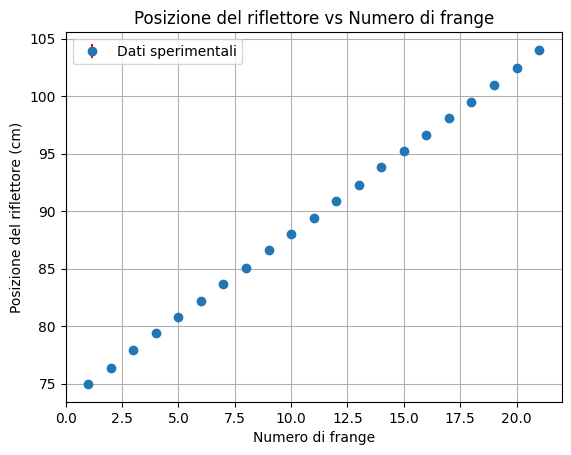

In [42]:
# minimi passati = 10
# errore sulle distanze = 0.2 cm
# errore sulle intensità = 0.02 V
x1 = 38.7
I1 = 0.82
x2 = 24.5
I2 = 0.87

x3 = 43.0
I3 = 1.1
x4 = 28.8
I4 = 0.83

x5 = 34.4
I5 = 0.83
x6 = 20.1
I6 = 0.86  

#Dati magici che mi ha dato babbo natale
frange = np.arange(1, 22)
posizioni = np.array([75.0, 76.4, 77.9, 79.4, 80.8, 82.2, 83.7, 85.1, 86.6, 88.0, 
                      89.4, 90.9, 92.3, 93.8, 95.2, 96.6, 98.1, 99.5, 101.0, 102.4, 104.0])
posizioni_err = [0.1 for i in posizioni]


plt.errorbar(frange, posizioni, yerr=posizioni_err, fmt='o', ecolor='r', label='Dati sperimentali')
plt.xlabel('Numero di frange')
plt.ylabel('Posizione del riflettore (cm)')
plt.title('Posizione del riflettore vs Numero di frange')
plt.grid()
plt.legend()
plt.show()


In [43]:
#stima lunghezza onda con frange vs posizione m sarà metà della lunghezza d'onda

def mod_lineare(x,m,q):
    return m*x +q

params, vals, errs, pval, dof, chi_quadro, cov = LS_fit(frange,posizioni,posizioni_err, mod_lineare, m=1,q=1)

m_best = vals[0]
m_err = errs[0]
print(f"Stima del coeff della retta è : {m_best:.3g} +- {m_err:.3g} ")
print(f"Quindi la lunghezza d'onda è: {2*m_best:.3g} +- {2*m_err:.3g} cm")


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.651 (χ²/ndof = 0.2)      │              Nfcn = 50               │
│ EDM = 8.29e-19 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │   1.444   │   0.004   │            │            │         │         │       │
│ 1 │ q    │   73.56   │   0.05    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────┐
│   │         m         q │
├───┼─────────────────────┤
│ m │   1.3e-05 -0.143e-3 │
│ q │ -0.143e-3   0.00205 │
└───┴─────────────────────┘

Stima del coeff della retta è : 1.44 +- 0.0036 
Quindi la lunghezza d'onda è: 2.89 +- 0.00721 cm


In [44]:
# Calcolo delle lunghezze d'onda 

mic_lambda_1 = (x1 - x2) / 10 * 2
mic_lambda_2 = (x3 - x4) / 10 * 2
mic_lambda_3 = (x5 - x6) / 10 * 2
#print(mic_lambda_1 , mic_lambda_2, mic_lambda_3)

mic_lambda_err = 0.2 
mic_sigma_lambda = np.sqrt(2 * (1/25)**2 * mic_lambda_err**2 ) # da formula della propagazione degli errori
mic_lambda_best = np.mean((mic_lambda_1, mic_lambda_2, mic_lambda_3))

print(f"Lambda best = {mic_lambda_best:.3g} +- {mic_sigma_lambda:.3g}")

Lambda best = 2.85 +- 0.0113


In [45]:
# test compatibilità

mic_lambda_comp = TestCompatibilita(mic_lambda_best, mic_sigma_lambda, 2.85, 0)
print(f"Test compatibilità lambda di Michelson: {mic_lambda_comp:.3g}")

Test compatibilità lambda di Michelson: 0.295


## Specchio di Lloyd

**Posizioni iniziali** (distanze dal centro)
* distanza specchio centro(shift) = $8 \pm 0.3$ cm
Per specchio di Lloyd abbiamo preso la distanza tra ricevitore ed emettitore reale, tra il punto di emissione e quello di ricezione.
* supporto-ricevitore = $5.5 \pm 0.3$ cm
* supporto-emettitore = $2.5 \pm 0.3$ cm
* Distanza12 emissione-ricezione = $100 \pm 1$ cm
* Distanza34 emissione-ricezione = $110 \pm 1$ cm


In [46]:
#Misure prese con specchio sottile
#h1 = 10.4
#v1 = 1.74
#h2 = 16.7
#v2 = 1.74
#Le misure h sono prese in cm, le misure in v sono prese in volt
#Incertezza lunghezza: 0.2 cm, Incertezza intensità: 0.03 volt
h_err = 0.2
v_err = 0.03

# prima misurazione
d12 = 100
d12_err = 1

h1 = 9.9
v1 = 1.64
h2 = 16.9
v2 = 1.7

# seconda misurazione
d34 = 110
d34_err = 1

h3 = 10.9
v4 = 1.40
h4 = 17.2
v4 = 1.5


In [47]:
# calcolo n, il numero del minimo per tutte le misurazioni, dato che per ottenere lambda serve n

n_1 = lloyd_n_frangia(d12, h1)
n_2 = lloyd_n_frangia(d12, h2)
n_3 = lloyd_n_frangia(d34, h3)
n_4 = lloyd_n_frangia(d34, h4)

#calcolo lambda per ogni misurazione
lambda_1 = lloyd(d12, h1, n_1)
lambda_2 = lloyd(d12, h2, n_2)
lambda_3 = lloyd(d34, h3, n_3)
lambda_4 = lloyd(d34, h4, n_4)

#calcolo errore su lambda
lambda_1_err = (np.sqrt(((2*d12 + 2*np.sqrt(4*h1**2 + d12**2))*d12_err)**2 + (8*h1*h_err)**2))/(n_1*np.sqrt(4*h1**2 + d12**2))
lambda_2_err = (np.sqrt(((2*d12 + 2*np.sqrt(4*h2**2 + d12**2))*d12_err)**2 + (8*h2*h_err)**2))/(n_2*np.sqrt(4*h2**2 + d12**2))
lambda_3_err = (np.sqrt(((2*d34 + 2*np.sqrt(4*h3**2 + d34**2))*d34_err)**2 + (8*h3*h_err)**2))/(n_3*np.sqrt(4*h3**2 + d34**2))
lambda_4_err = (np.sqrt(((2*d34 + 2*np.sqrt(4*h4**2 + d34**2))*d34_err)**2 + (8*h4*h_err)**2))/(n_4*np.sqrt(4*h4**2 + d34**2))

#Medio per la prima e la seconda esperienza
lambda_medio_1 = np.mean([lambda_1, lambda_2])
lambda_medio_1_err = np.sqrt(lambda_1_err**2 + lambda_2_err**2)

#Medio per la terza e la quarta esperienza
lambda_medio_2 = np.mean([lambda_3, lambda_4])
lambda_medio_2_err = np.sqrt(lambda_3_err**2 + lambda_4_err**2)

#Test di compatibilità
comp_lambda_1 = TestCompatibilita(lambda_medio_1, lambda_medio_1_err, 2.85, 0)
comp_lambda_2 = TestCompatibilita(lambda_medio_2, lambda_medio_2_err, 2.85, 0)
comp_lambda_3 = TestCompatibilita(lambda_medio_1, lambda_medio_1_err, lambda_medio_2, lambda_medio_2_err)

#Stampa dei risultati
print(f"Lambda 1: {lambda_medio_1:.3g} +- {lambda_medio_1_err:.1g}")
print(f"Lambda 2: {lambda_medio_2:.3g} +- {lambda_medio_2_err:.1g}")
print(f"Distanza in deviazioni standard 1: {comp_lambda_1:.2g}")
print(f"Distanza in deviazioni standard 2: {comp_lambda_2:.2g}")
print(f"Distanza in deviazioni standard 3: {comp_lambda_3:.2g}")

print(n_1)
print(n_2)
print(n_3)
print(n_4)

Lambda 1: 2.86 +- 0.07
Lambda 2: 2.85 +- 0.06
Distanza in deviazioni standard 1: 0.11
Distanza in deviazioni standard 2: 0.079
Distanza in deviazioni standard 3: 0.031
78
86
86
93
